In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from scipy.ndimage import gaussian_filter
from scipy.signal import savgol_filter
import matplotlib.colors as mcolors
from XRDutils_getdata import *

def q_to_twotheta(q,Kalpha=1.5406):
    return 2*np.arcsin(q*Kalpha/(4*np.pi))*180/np.pi

def twotheta_to_q(twotheta,Kalpha=1.5406):
    return np.sin(np.radians(twotheta)/2)*4*np.pi/Kalpha

def d_to_q(d,Kalpha=1.5406):
    return 2*np.pi/d

def q_to_d(q,Kalpha=1.5406):
    return 2*np.pi/q

def calc_fully_strained(a_bulk,a_substrate, v=0.3):
    parallel_strain=(a_substrate-a_bulk)/a_bulk

    c_strained=a_bulk*(1-2*v*parallel_strain/(1-v))
    return parallel_strain, c_strained

def getdata(fname):
    #function to get the metadata and scan data from the file and populate the scdata class to save the data
    print('getting data from '+fname)
    machine = XRDmachine('NSLxrdml')

    d=scdata(fname, machine)
    data_line_nums=[]
    twotheta_range_line_nums=[]
    omega_line_nums=[]
    with open(fname) as file:    
        lines = file.readlines()
    twotheta_range_key=machine.sttwothetaangl+'"2Theta"'
    omega_key=machine.sttwothetaangl+'"Omega"'
    attenlist=[1]
    for num, line in enumerate(lines):
        if machine.timestp in line:
            d.timestp = line.split(machine.timestp)[-1].split('<')[0].split(machine.datestp)[-1].split('-')[0]
            d.datestp = line.split(machine.timestp)[-1].split('<')[0].split(machine.datestp)[0]
        if twotheta_range_key in line:
            twotheta_range_line_nums.append(num+1)
        if omega_key in line:
            omega_line_nums.append(num+1)
        if machine.datstart in line:
            data_line_nums.append(num)
        if machine.wvlnth in line:
            d.wavelength = float(line.split(machine.wvlnth)[1].split('<')[0])
        if machine.tpp in line:
            d.tpp=float(line.split(machine.tpp)[1].split('<')[0])
        if machine.atten in line:
            attenlist=line.split(machine.atten)[1].split('<')[0]
            attenlist=attenlist.split(machine.delimiter)
            attenlist=[float(i) for i in attenlist]

    number_of_omega_positions=len(omega_line_nums)
    if len(twotheta_range_line_nums) != number_of_omega_positions or len(data_line_nums) != number_of_omega_positions:
        raise
    data = np.zeros((3,255,number_of_omega_positions)) 
    # data is of the form [omega, twotheta, counts] for each separate omega-2theta position (each of those has 255 different twothetas and counts for a given omega offset) 

    for i in range(number_of_omega_positions):
        twotheta_start=float(lines[twotheta_range_line_nums[i]].split('<startPosition>')[-1].split('<')[0])
        twotheta_end=float(lines[twotheta_range_line_nums[i]+1].split('<endPosition>')[-1].split('<')[0])
        omega=float(lines[omega_line_nums[i]].split('<commonPosition>')[-1].split('<')[0])
        ylist=lines[data_line_nums[i]].split(machine.datstart)[1].split('<')[0]
        ylist=ylist.split(machine.delimiter)
        ylist=[float(i) for i in ylist]
        twothetas=np.linspace(twotheta_start,twotheta_end,len(ylist))
        data[0,:,i]=np.ones(255)*omega
        data[1,:,i]=twothetas
        data[2,:,i]=ylist
    # d.datadf['x']=np.linspace(d.sttwothetaangl,d.endtwothetaangl,len(ylist))
    # d.datadf['y']=ylist
    # d.stepsize=d.datadf['x'].iloc[1]-d.datadf['x'].iloc[0]
    d.data=data
    return d

def convert_to_q_space(d):
    """
    Convert (omega, two-theta) scan data to reciprocal space (q_x, q_z).

    Parameters:
        data (numpy array): Shape (3, 255, N)
            - data[0, :, :] = omega values
            - data[1, :, :] = two-theta values
            - data[2, :, :] = intensity counts
        wavelength (float): X-ray wavelength in Å.

    Returns:
        q_x, q_z, counts (numpy arrays) for plotting.
    """
    data=d.data
    wavelength=d.wavelength
    omega_rad = np.radians(data[0, :, :])  # Convert omega to radians
    theta_rad = np.radians(data[1, :, :]/2)  # Convert 2Theta to radians

    # Calculate Qz and Qx
    k = 2*np.pi / wavelength
    d.Qx = k * (np.cos(omega_rad)-np.cos(2*theta_rad - omega_rad))
    d.Qz = k * (np.sin(omega_rad)+np.sin(2*theta_rad - omega_rad))
    d.counts = data[2, :, :]  # Intensity data remains unchanged

    return d

def plot_rsm(d, log_scale=True, smooth_sigma=1, contours=True, contour_levels = [1,2,5,10,200,1000,10000]):
    """
    Plot a Reciprocal Space Map (RSM) with raw intensity data and smoothed contours.

    Parameters:
        Qx, Qz : 2D numpy arrays
            Meshgrid arrays of reciprocal space coordinates.
        counts : 2D numpy array
            Intensity data at each (Qx, Qz) point.
        log_scale : bool, optional
            If True, applies a logarithmic color scale (default: True).
        contour_levels : int or list, optional
            Number of contour levels or specific levels (default: 10).
        smooth_sigma : float, optional
            Standard deviation for Gaussian smoothing (default: 1).
    """
    Qx=d.Qx
    Qz=d.Qz
    counts=d.counts
    plt.figure(figsize=(8, 6))

    # Apply Gaussian smoothing to the counts (for contour plot only)
    smoothed_counts = gaussian_filter(counts, sigma=smooth_sigma)

    # Set up the colormap
    if log_scale:
        norm = mcolors.LogNorm(vmin=np.max([np.min(counts[counts > 0]), 1]), vmax=np.max(counts))  # Log scale for colormap
        label = "Counts"  # Colorbar shows raw counts
    else:
        norm = None  # Linear scale
        label = "Intensity"

    # Plot raw intensity data with logarithmic colormap scaling
    cmap = plt.cm.viridis
    cmap.set_bad('black')  # Forces NaNs to be black
    mesh = plt.pcolormesh(Qx, Qz, counts, shading='auto', cmap=cmap, norm=norm)

    # Define contour levels
    

    # Overlay smoothed logarithmic contours
    if contours:
        plt.contour(Qx, Qz, smoothed_counts, levels=contour_levels, colors='red', linewidths=0.3)

    # Labels and title
    plt.xlabel(r"$Q_x$ ($\mathrm{\AA}^{-1}$)")
    plt.ylabel(r"$Q_z$ ($\mathrm{\AA}^{-1}$)")
    plt.colorbar(mesh, label=label)
    plt.title("{}".format(d.name.split('\\')[-2]))
    
def calculate_lattice_params(h, k, l, Qx, Qz):
    """
    Calculate in-plane (a_IP) and out-of-plane (c_OP) tetragonal lattice parameters
    given Miller indices (hkl) and reciprocal space coordinates (Qx, Qz).
    
    Parameters:
        h, k, l : int
            Miller indices of the Bragg reflection.
        Qx, Qz : float
            Reciprocal space coordinates in Å⁻¹.

    Returns:
        a_IP : float
            In-plane lattice parameter in Å.
        c_OP : float
            Out-of-plane lattice parameter in Å.
    """
    if Qx == 0:
        raise ValueError("Qx cannot be zero; check your input values.")

    # Calculate lattice parameters
    a_IP = (2 * np.pi / Qx) * np.sqrt(h**2 + k**2)
    c_OP = (2 * np.pi * l) / Qz

    return a_IP, c_OP
    
def calculate_Qs(hkl, a_in_plane, c_out_of_plane):
    """
    Calculate Qx (in-plane) and Qz (out-of-plane) from (hkl) and lattice parameters.

    Parameters:
        h, k, l : int
            Miller indices of the reflection.
        a_in_plane : float
            In-plane lattice parameter (Å), assuming a = b.
        c_out_of_plane : float
            Out-of-plane lattice parameter (Å).

    Returns:
        Qx, Qz : float
            Reciprocal space coordinates in Å⁻¹.
    """
    (h,k,l)=hkl
    # Reciprocal lattice parameters
    a_star = 2 * np.pi / a_in_plane  # In-plane reciprocal lattice parameter
    c_star = 2 * np.pi / c_out_of_plane  # Out-of-plane reciprocal lattice parameter

    # Compute Qx and Qz
    Qx = (h**2 + k**2)**0.5 * a_star  # In-plane component
    Qz = l * c_star  # Out-of-plane component

    return Qx, Qz

def plot_relaxation_line(ax, a_sub, a_film, poisson, hkl, phi=0, color='white', linestyle='-', label='Relaxation Line'):

    h, k, l = hkl
    phi_rad = np.radians(phi)  # Convert to radians

    # Compute initial Qx, Qz for the fully strained state (matches substrate)
    qx_sub = 2*np.pi/a_sub *np.sqrt(h**2+k**2)

    # Generate relaxation path: strain from fully strained (ε_parallel = 0) to fully relaxed (ε_parallel = (a_bulk - a_sub) / a_bulk)
    c_strained=calc_fully_strained(a_film,a_sub, v=poisson)[1]
    
    # Compute fully relaxed Qx, Qz (matches bulk film)
    qx_strained,qz_strained=calculate_Qs(hkl,a_sub,c_strained)
    qx_relaxed,qz_relaxed=calculate_Qs(hkl,a_film,a_film)

    # Compute interpolated Qx, Qz along the relaxation path
    qx_values = np.linspace(qx_strained,qx_relaxed,100)
    qz_values = np.linspace(qz_strained,qz_relaxed,100)

    # Plot the relaxation line
    ax.plot(qx_values, qz_values, linestyle=linestyle, color=color, label=label, linewidth=2)

    if label:
        ax.legend()

    plt.draw()  # Ensure the plot updates

def plot_reference_line(ax, value, orientation='vertical', color='white', linestyle='--', linewidth=1.5, label=None):
    """
    Plot a reference line (vertical or horizontal) on a given matplotlib axis.

    Parameters:
        ax : matplotlib axis
            Axis to draw the line on.
        value : float
            Position where the line is drawn (x or y depending on orientation).
        orientation : str
            'vertical' or 'horizontal' (default: 'vertical').
        color : str
            Color of the line (default: 'white').
        linestyle : str
            Line style (default: '--').
        linewidth : float
            Width of the line (default: 1.5).
        label : str, optional
            Label for the legend.

    Returns:
        None
    """
    if orientation == 'vertical':
        ax.axvline(x=value, color=color, linestyle=linestyle, linewidth=linewidth, label=label)
    elif orientation == 'horizontal':
        ax.axhline(y=value, color=color, linestyle=linestyle, linewidth=linewidth, label=label)
    else:
        raise ValueError("Orientation must be 'vertical' or 'horizontal'.")

    if label:
        ax.legend()
    plt.draw()

def plot_q_point(ax, qx, qz, color='black', marker='o', label=None, markersize=8):
    """
    Plots a single point in reciprocal space (qx, qz) on an RSM plot.

    Parameters:
        ax : matplotlib axis
            The axis where the RSM is plotted.
        qx : float
            Qx coordinate of the point.
        qz : float
            Qz coordinate of the point.
        color : str, optional
            Color of the point (default is black).
        marker : str, optional
            Marker style (default is 'o').
        label : str, optional
            Label for the point in the legend.
        markersize : int, optional
            Size of the marker.

    Returns:
        None (plots directly on the given axis).
    """
    ax.scatter(qx, qz, color=color, marker=marker, s=markersize**2, label=label, zorder=15)
    if label:
        ax.legend()
    plt.draw()  # Ensure the plot updates

def plot_linecut(d, direction='Qx', value=None, tol=0.001, log_scale=True, ax=None, smooth=0):
    """
    Plot a linecut of the RSM data along Qx or Qz direction at a fixed Qz or Qx value.

    Parameters:
        d : object
            Data object containing Qx, Qz, and counts arrays.
        direction : str
            Direction of the linecut: 'Qx' or 'Qz' (default: 'Qx').
        value : float
            Fixed value of Qz (if direction='Qx') or Qx (if direction='Qz') to take the slice at.
        tol : float
            Tolerance around `value` for slicing (default: 0.001 Å⁻¹).
        log_scale : bool
            Whether to plot the intensity on a log scale.
        ax : matplotlib axis, optional
            Axis to plot on. If None, a new figure and axis is created.

    Returns:
        fig, ax : matplotlib figure and axis handles.
    """
    Qx = d.Qx
    Qz = d.Qz
    counts = d.counts

    if direction == 'Qx':
        if value is None:
            raise ValueError("You must specify a Qz value for a Qx linecut.")
        mask = np.abs(Qz - value) < tol
        x_vals = Qx[mask]
        y_vals = counts[mask]
        xlabel = r"$Q_x$ ($\mathrm{\AA}^{-1}$)"
    elif direction == 'Qz':
        if value is None:
            raise ValueError("You must specify a Qx value for a Qz linecut.")
        mask = np.abs(Qx - value) < tol
        x_vals = Qz[mask]
        y_vals = counts[mask]
        xlabel = r"$Q_z$ ($\mathrm{\AA}^{-1}$)"
    else:
        raise ValueError("Direction must be 'Qx' or 'Qz'.")

    if len(x_vals) == 0:
        raise ValueError("No data points found for the specified linecut. Try increasing `tol`.")

    # Sort for plotting
    sort_idx = np.argsort(x_vals)
    x_vals = x_vals[sort_idx]
    y_vals = y_vals[sort_idx]

    if smooth>0:
        y_vals=savgol_filter(y_vals,smooth,0)

    # Plot
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 4))
    else:
        fig = ax.figure

    if log_scale:
        ax.semilogy(x_vals, y_vals, 'k-')
        ax.set_ylabel("Log(Intensity)")
    else:
        ax.plot(x_vals, y_vals, 'k-')
        ax.set_ylabel("Intensity")

    ax.set_xlabel(xlabel)
    ax.set_title(f"Linecut at fixed {'Qz' if direction == 'Qx' else 'Qx'} = {value:.3f} Å⁻¹")

    return fig, ax

getting data from C:\Users\justi\Research\Data\XRD\LSD319_Pt(2)_LFO(10)_STO(001)\RSM_1D_103_slow.xrdml


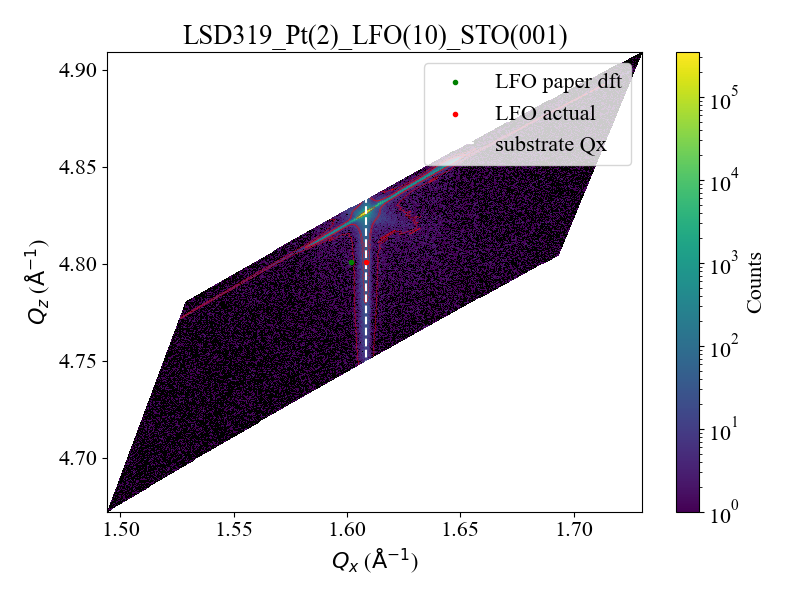

In [2]:
%matplotlib widget
plt.close('all')
sto_lc=3.905
lfo_bulk_a=3.922
lfo_bulk_c=3.930
lfo_ip_a_paper=3.923
hkl=(1,0,3)
d=getdata(r"C:\Users\justi\Research\Data\XRD\LSD319_Pt(2)_LFO(10)_STO(001)\RSM_1D_103_slow.xrdml")
# Convert to q-space
d = convert_to_q_space(d)

# Plot the q-space map
plot_rsm(d, log_scale=True, smooth_sigma=2, contours=True,contour_levels=[2,18,23,20000,140000])
ax=plt.gca()
plot_q_point(ax, *calculate_Qs((1,0,3),lfo_ip_a_paper,3.926), color='green', marker='o', label="LFO paper dft", markersize=3)
plot_q_point(ax, 1.6085,4.801, color='red', marker='o', label="LFO actual", markersize=3)
plot_reference_line(ax, 1.6085, orientation='vertical', color='white', linestyle='--', linewidth=1.5, label='substrate Qx')
# plot_relaxation_line(ax, mgo, bulk_nio, 0.21, hkl, color='white', linestyle='--', label='Relaxation Line')
fig=plt.gcf()
# fig.savefig(r'C:\Users\justi\Documents\Updates\NiO_Myers_2_27_25\XF126RSM')
plt.show()

(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'Linecut at fixed Qx = 1.609 Å⁻¹'}, xlabel='$Q_z$ ($\\mathrm{\\AA}^{-1}$)', ylabel='Log(Intensity)'>)

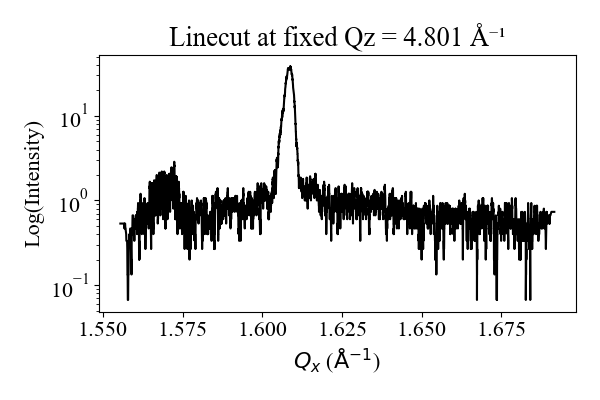

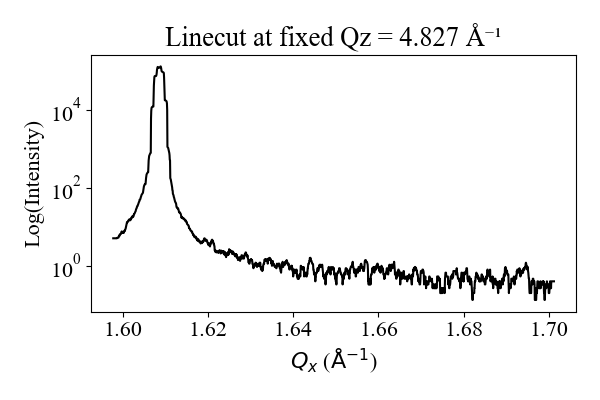

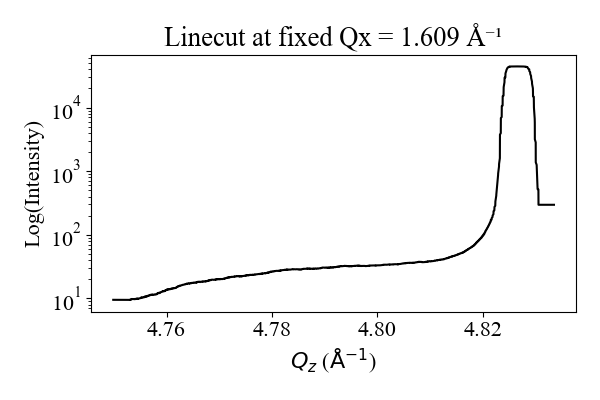

In [4]:
plot_linecut(d, direction='Qx', value=4.801, tol=0.003, log_scale=True, ax=None,smooth=15)
plot_linecut(d, direction='Qx', value=4.82677, tol=0.001, log_scale=True, ax=None, smooth=15)
plot_linecut(d, direction='Qz', value=1.6085, tol=0.001, log_scale=True, ax=None, smooth=100)

In [107]:
print('Substrate \na lattice parameter {:4f}A\nc lattice parameter {:.4f}\n'.format(*calculate_lattice_params(1,0,3,1.6085,4.8267)))
print('Film \na lattice parameter {:4f}A\nc lattice parameter {:.4f}\n'.format(*calculate_lattice_params(1,0,3,1.6085,4.801)))

Substrate 
a lattice parameter 3.906239A
c lattice parameter 3.9053

Film 
a lattice parameter 3.906239A
c lattice parameter 3.9262



getting data from C:\Users\justi\Research\Data\XRD\XF145_NiO(20min)_MgO(001)D_3p5in_600C_45W_6%O2\224_RSM_vfine_XF145.xrdml


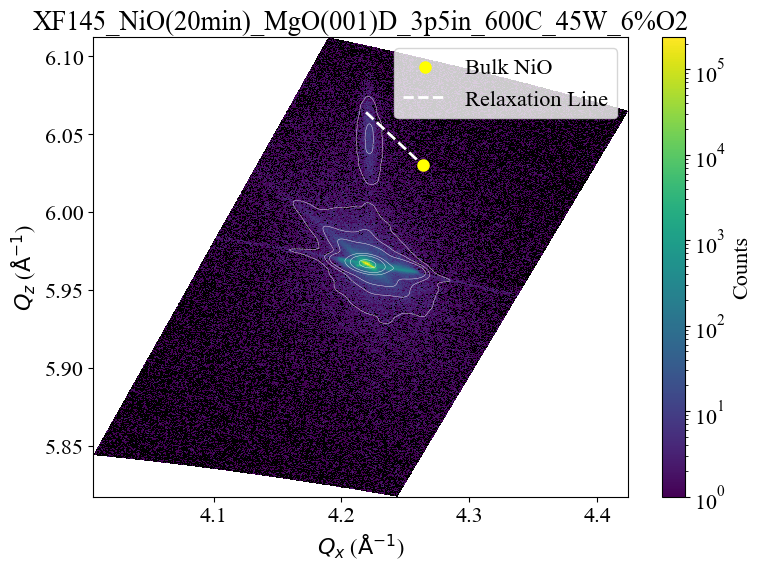

In [62]:
%matplotlib inline
plt.close('all')
bulk_nio=4.168
mgo=4.212
hkl=(2,2,4)
d=getdata(r"C:\Users\justi\Research\Data\XRD\XF145_NiO(20min)_MgO(001)D_3p5in_600C_45W_6%O2\224_RSM_vfine_XF145.xrdml")
# Convert to q-space
d = convert_to_q_space(d)

# Plot the q-space map
plot_rsm(d, log_scale=True, smooth_sigma=5, contours=True, contour_levels = [2,4.5,10,200,1000,10000]  )
ax=plt.gca()
plot_q_point(ax, *calculate_Qs((2,2,4),bulk_nio,bulk_nio), color='yellow', marker='o', label="Bulk NiO", markersize=8)
plot_relaxation_line(ax, mgo, bulk_nio, 0.21, hkl, color='white', linestyle='--', label='Relaxation Line')
fig=plt.gcf()
fig.savefig(r'C:\Users\justi\Documents\Updates\NiO_Myers_2_27_25\XF145RSM')
plt.show()

getting data from C:\Users\justi\Research\Data\XRD\XF143_NiO(75min)_MgO(001)D_3p5in_600C_45W_6%O2\224_RSM_fine_XF143.xrdml


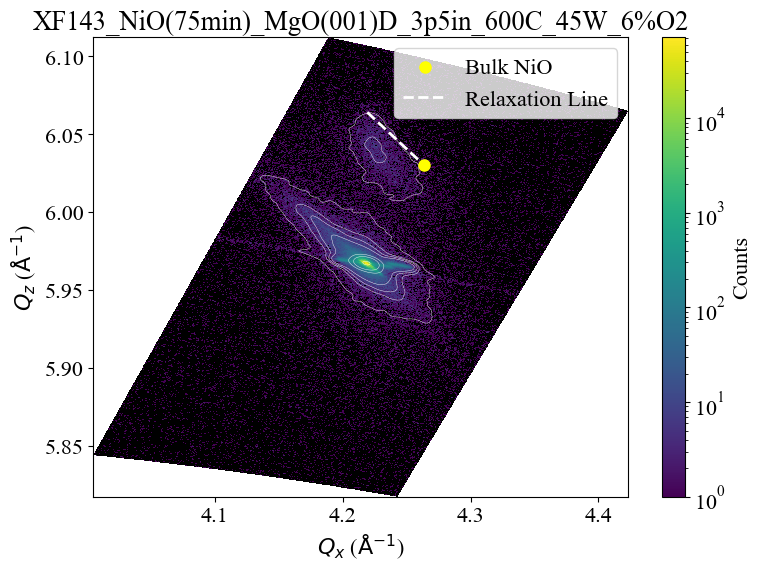

In [63]:
%matplotlib inline
plt.close('all')
bulk_nio=4.168
mgo=4.212
hkl=(2,2,4)
d=getdata(r"C:\Users\justi\Research\Data\XRD\XF143_NiO(75min)_MgO(001)D_3p5in_600C_45W_6%O2\224_RSM_fine_XF143.xrdml")
# Convert to q-space
d = convert_to_q_space(d)

# Plot the q-space map
plot_rsm(d, log_scale=True, smooth_sigma=4, contours=True, contour_levels = [1,3,5,10,200,1000,10000]  )
ax=plt.gca()
plot_q_point(ax, *calculate_Qs((2,2,4),bulk_nio,bulk_nio), color='yellow', marker='o', label="Bulk NiO", markersize=8)
plot_relaxation_line(ax, mgo, bulk_nio, 0.21, hkl, color='white', linestyle='--', label='Relaxation Line')
fig=plt.gcf()
fig.savefig(r'C:\Users\justi\Documents\Updates\NiO_Myers_2_27_25\XF143RSM')
plt.show()

getting data from C:\Users\justi\Research\Data\XRD\XF144_NiO(50min)_MgO(001)D_3p5in_600C_45W_6%O2\224_RSM_fine_XF144.xrdml


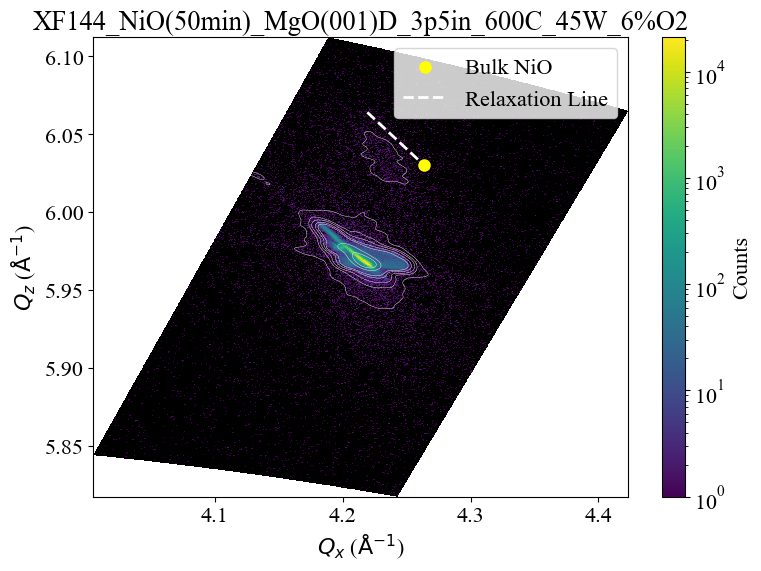

In [64]:
%matplotlib inline
plt.close('all')
bulk_nio=4.168
mgo=4.212
hkl=(2,2,4)
d=getdata(r"C:\Users\justi\Research\Data\XRD\XF144_NiO(50min)_MgO(001)D_3p5in_600C_45W_6%O2\224_RSM_fine_XF144.xrdml")
# Convert to q-space
d = convert_to_q_space(d)

# Plot the q-space map
plot_rsm(d, log_scale=True, smooth_sigma=4, contours=True,contour_levels = [0.4,1,2,5,10,200,1000,10000]  )
ax=plt.gca()
plot_q_point(ax, *calculate_Qs((2,2,4),bulk_nio,bulk_nio), color='yellow', marker='o', label="Bulk NiO", markersize=8)
plot_relaxation_line(ax, mgo, bulk_nio, 0.21, hkl, color='white', linestyle='--', label='Relaxation Line')
fig=plt.gcf()
fig.savefig(r'C:\Users\justi\Documents\Updates\NiO_Myers_2_27_25\XF144RSM')
plt.show()

getting data from C:\Users\justi\Research\Data\XRD\XF139_NiO(30min)_MgO(001)D_3p5in_500C_45W_6%O2\RSM_224_fine_XF139.xrdml


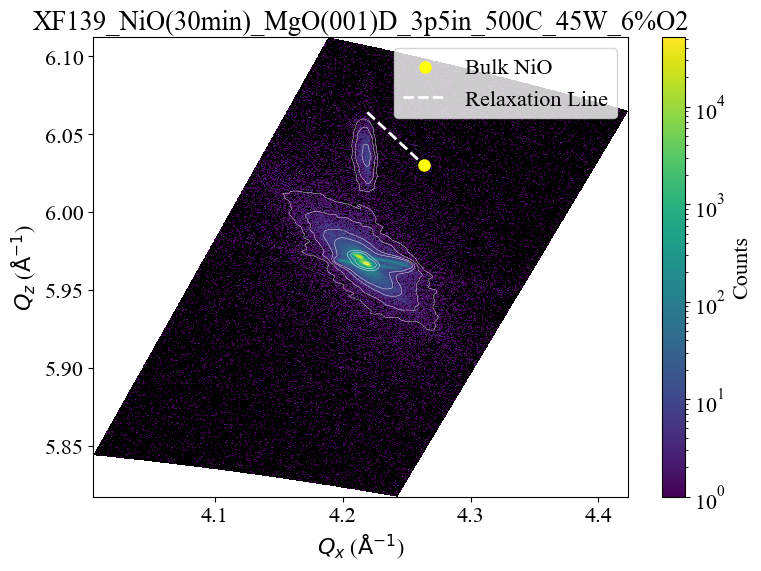

In [65]:
%matplotlib inline
plt.close('all')
bulk_nio=4.168
mgo=4.212
hkl=(2,2,4)
d=getdata(r"C:\Users\justi\Research\Data\XRD\XF139_NiO(30min)_MgO(001)D_3p5in_500C_45W_6%O2\RSM_224_fine_XF139.xrdml")
# Convert to q-space
d = convert_to_q_space(d)

# Plot the q-space map
plot_rsm(d, log_scale=True, smooth_sigma=3, contours=True,contour_levels = [1,2,5,10,200,1000,10000]  )
ax=plt.gca()
plot_q_point(ax, *calculate_Qs((2,2,4),bulk_nio,bulk_nio), color='yellow', marker='o', label="Bulk NiO", markersize=8)
plot_relaxation_line(ax, mgo, bulk_nio, 0.21, hkl, color='white', linestyle='--', label='Relaxation Line')
fig=plt.gcf()
fig.savefig(r'C:\Users\justi\Documents\Updates\NiO_Myers_2_27_25\XF139RSM')
plt.show()

getting data from C:\Users\justi\Research\Data\XRD\XF145_NiO(20min)_MgO(001)D_3p5in_600C_45W_6%O2\224_RSM_fine_iCore_XF145.xrdml


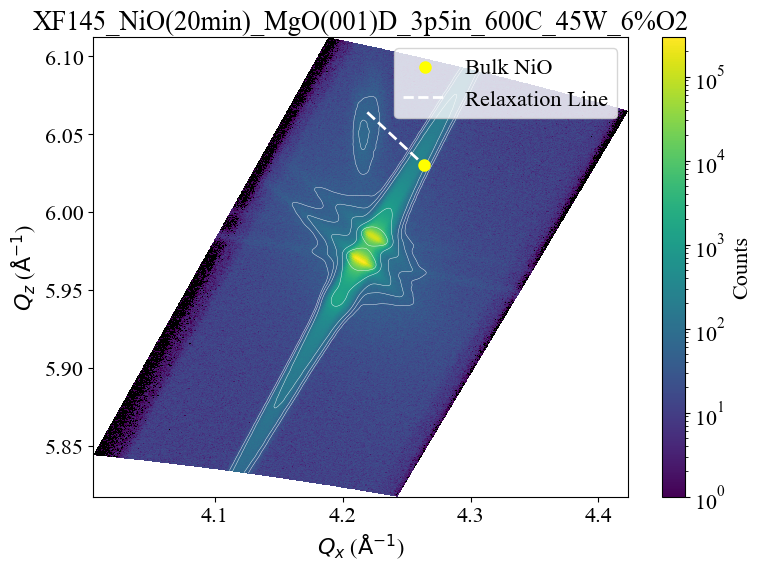

In [76]:
%matplotlib inline
plt.close('all')
bulk_nio=4.168
mgo=4.212
hkl=(2,2,4)
d=getdata(r"C:\Users\justi\Research\Data\XRD\XF145_NiO(20min)_MgO(001)D_3p5in_600C_45W_6%O2\224_RSM_fine_iCore_XF145.xrdml")
# Convert to q-space
d = convert_to_q_space(d)

# Plot the q-space map
plot_rsm(d, log_scale=True, smooth_sigma=3, contours=True,contour_levels = [40,60,120,1000,10000]  )
ax=plt.gca()
plot_q_point(ax, *calculate_Qs((2,2,4),bulk_nio,bulk_nio), color='yellow', marker='o', label="Bulk NiO", markersize=8)
plot_relaxation_line(ax, mgo, bulk_nio, 0.21, hkl, color='white', linestyle='--', label='Relaxation Line')
fig=plt.gcf()
fig.savefig(r'C:\Users\justi\Documents\Updates\NiO_Myers_2_27_25\XF139RSM_icore')
plt.show()

In [5]:
print('Substrate \na lattice parameter {:4f}A\nc lattice parameter {:.4f}\n'.format(*calculate_lattice_params(2,2,4,4.220,5.967)))
print('Film \na lattice parameter {:4f}A\nc lattice parameter {:.4f}\n'.format(*calculate_lattice_params(2,2,4,4.224,6.026)))

Substrate 
a lattice parameter 4.211263A
c lattice parameter 4.2120

Film 
a lattice parameter 4.207276A
c lattice parameter 4.1707



In [19]:
print(2*1.5406/(2*np.sin(43.43/2 *np.pi/180)))

4.163896423501698


In [ ]:
calculate_qs(2,2,4,4.168)